# Question 1

Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as scs
from statsmodels.stats.power import tt_ind_solve_power
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)

import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3

In [2]:
from numpy import std, mean, sqrt

#correct if the population S.D. is expected to be equal for the two groups.
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)
#https://stackoverflow.com/questions/21532471/how-to-calculate-cohens-d-in-python

In [3]:
def test_normality(x):
    """
    h0: x is normal
    ha: x is not normal
    
    if pvalue < 0.5 
        we reject the null hypothesis and our data is not normal
    if pvalue > 0.5
        we fail to rejrect the null hypothesis and our data is normal
    """
    t, p = scs.shapiro(x)
    if p < 0.5:
        print(f"Data is not normal with \npvalue={p}")
        return False
    else:
        print(f"Data is normal with \npvalue={p}")
        return True

def test_equal_variances(x1, x2):
    """
    h0: var_x1 = var_x2
    ha: var_x1 != var_x2
    
    """
    t, p = scs.levene(x1, x2)
    if p < 0.5:
        print(f"p = {p}\nThe data does not have equal variances ")
        return False
    else:
        print(f"p = {p}\nThe data have equal variances")
        return True

In [4]:
conn = sqlite3.connect("./Northwind_small.sqlite")

In [5]:
cursor = conn.cursor()

In [6]:
res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
res

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

In [7]:
query = "select * from orderdetail"

df = pd.read_sql(query, conn)
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [8]:
df["Discount"].unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

### Let's just test discount vs non-discount

In [9]:
has_discount = []

for discount in df["Discount"]:
    if discount > 0.0:
        has_discount.append(1)
    else:
        has_discount.append(0)
    

In [10]:
df["HasDiscount"] = has_discount
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,HasDiscount
0,10248/11,10248,11,14.0,12,0.0,0
1,10248/42,10248,42,9.8,10,0.0,0
2,10248/72,10248,72,34.8,5,0.0,0
3,10249/14,10249,14,18.6,9,0.0,0
4,10249/51,10249,51,42.4,40,0.0,0


//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


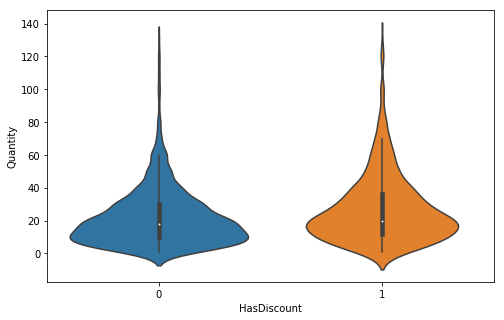

In [11]:
plt.figure(figsize=(8, 5))
sns.violinplot(x='HasDiscount', y='Quantity', data=df)
plt.show()

In [14]:
df.HasDiscount.value_counts()

0    1317
1     838
Name: HasDiscount, dtype: int64

In [22]:
quantity_discount = df.loc[df['HasDiscount'] == 1, ['Quantity']]
quantity_nodiscount = df.loc[df['HasDiscount'] == 0, ['Quantity']]

//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


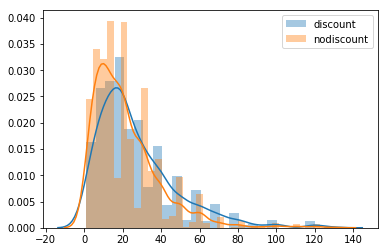

In [30]:
sns.distplot(quantity_discount, label="discount")
sns.distplot(quantity_nodiscount,label="nodiscount")

plt.legend()

In [ ]:
sns.distplot()

### Violin Plot Summary
both plots look very similar. I think discount will have a small effect on quantity

### To test if there is a difference in the mean quantity sold by discount type.   

In order to do this, we need to use a **independent ttest*

The assumptions of this test are:
- [x] Our two samples are independent of one another
- Our samples are normally distributed
- Our samples have equal variance -> student ttest
- Our samples have unequal varaince -> welch's ttest

### Let's test for normality using a Shapiro test

In [31]:
discounts = df.loc[df["HasDiscount"]==1, "Quantity"]
non_discounts = df.loc[df["HasDiscount"]==0, "Quantity"]

In [32]:
test_normality(discounts)

Data is not normal with 
pvalue=6.88120409395894e-26


False

In [33]:
test_normality(non_discounts)

Data is not normal with 
pvalue=3.803856556577728e-34


False

In [34]:
discounts.shape[0]

838

### We need normality, so we're going to use sampling distributions

In [35]:
discount_sample_means = []
non_discount_sample_means = []

for sample_number in range(100):
    # I'm using bootstrap sampling
    dis_samp = np.random.choice(discounts, size=discounts.shape[0], replace=True).mean()
    discount_sample_means.append(dis_samp)
    
    non_dis_samp = np.random.choice(non_discounts, size=non_discounts.shape[0], replace=True).mean()
    non_discount_sample_means.append(non_dis_samp)
print("finished")

finished


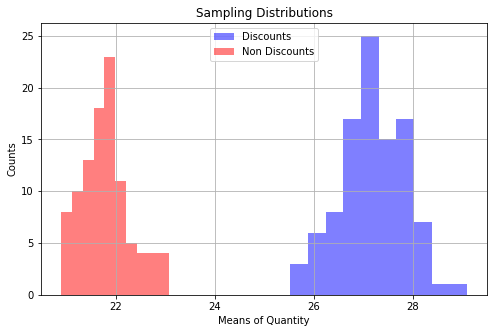

In [36]:
plt.figure(figsize=(8, 5))
plt.grid()
plt.hist(discount_sample_means, alpha=0.5, color='b', label="Discounts")
plt.hist(non_discount_sample_means, alpha=0.5, color='r', label="Non Discounts")
plt.legend()
plt.title("Sampling Distributions")
plt.xlabel("Means of Quantity")
plt.ylabel("Counts")
plt.show()

In [37]:
test_normality(discount_sample_means)
test_normality(non_discount_sample_means)

Data is normal with 
pvalue=0.8421024680137634
Data is not normal with 
pvalue=0.028036639094352722


False

In [38]:
test_equal_variances(discount_sample_means, non_discount_sample_means)

p = 0.005668496145942159
The data does not have equal variances 


False

# Let's run our T-Test

In [ ]:
# H0: mu_1 = mu_2
# Ha: mu_1 != mu_2

In [39]:
scs.ttest_ind(discount_sample_means, non_discount_sample_means)

Ttest_indResult(statistic=64.37794472188986, pvalue=9.919835602014959e-135)

In [40]:
#welches
scs.ttest_ind(discount_sample_means, non_discount_sample_means, equal_var=False)

Ttest_indResult(statistic=64.37794472188986, pvalue=3.915277820894006e-128)

In [41]:
#With a p value of 0, we know our means are not equal so we reject the null hypothesis H0

# Now I run a simulation using the mean and sample standard deviation

In [ ]:
dis_mu = np.mean(discount_sample_means)
dis_std = np.std(discount_sample_means, ddof = 1)

non_dis_mu = np.mean(non_discount_sample_means)
non_dis_std = np.std(non_discount_sample_means, ddof = 1)

In [ ]:
dis_samp = np.random.normal(loc = dis_mu, scale = dis_std, size = 50)
non_dis_samp = np.random.normal(loc = non_dis_mu, scale = non_dis_std, size = 50)

In [ ]:
plt.figure(figsize=(8, 5))
plt.grid()
plt.hist(dis_samp, alpha=0.5, color='b', label="Discounts")
plt.hist(non_dis_samp, alpha=0.5, color='r', label="Non Discounts")
plt.legend()
plt.title("Sampling Distributions")
plt.xlabel("Means of Quantity")
plt.ylabel("Counts")
plt.show()

In [ ]:
scs.ttest_ind(dis_samp, non_dis_samp, equal_var=False)
#welches

## Calculate Cohen's D

In [44]:
# effect size across quantities in an order
cohen_d(quantity_discount, quantity_nodiscount)

Quantity    0.286278
dtype: float64

In [42]:
# effect across the mean of samples of quantities in orders
effect_size = cohen_d(discount_sample_means, non_discount_sample_means)
effect_size

9.104416254340206

In [43]:
power = tt_ind_solve_power(effect_size = effect_size, nobs1 = 100, alpha = 0.5)
power

1.0

# Conclusion

In [47]:
df['Quantity'].groupby(df['Discount']).describe()

,count,mean,std,min,25%,50%,75%,max
Discount,,,,,,,,
0.00,1317.0,21.715262,17.507493,1.0,10.0,18.0,30.0,130.0
0.01,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.02,2.0,2.000000,1.414214,1.0,1.5,2.0,2.5,3.0
0.03,3.0,1.666667,0.577350,1.0,1.5,2.0,2.0,2.0
0.04,1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
0.05,185.0,28.010811,22.187685,1.0,14.0,20.0,40.0,120.0
0.06,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.10,173.0,25.236994,21.186503,2.0,10.0,20.0,30.0,130.0
0.15,157.0,28.382166,20.923099,2.0,15.0,21.0,40.0,100.0


Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
 0.0    0.01  -19.7153 -80.3306 40.9001 False 
 0.0    0.02  -19.7153 -62.593  23.1625 False 
 0.0    0.03  -20.0486 -55.0714 14.9742 False 
 0.0    0.04  -20.7153 -81.3306 39.9001 False 
 0.0    0.05   6.2955   1.5381   11.053  True 
 0.0    0.06  -19.7153 -80.3306 40.9001 False 
 0.0    0.1    3.5217  -1.3783   8.4217 False 
 0.0    0.15   6.6669   1.551   11.7828  True 
 0.0    0.2    5.3096   0.2508  10.3684  True 
 0.0    0.25   6.525    1.3647  11.6852  True 
 0.01   0.02    0.0    -74.2101 74.2101 False 
 0.01   0.03  -0.3333  -70.2993 69.6326 False 
 0.01   0.04    -1.0   -86.6905 84.6905 False 
 0.01   0.05  26.0108  -34.745  86.7667 False 
 0.01   0.06    0.0    -85.6905 85.6905 False 
 0.01   0.1    23.237  -37.5302 84.0042 False 
 0.01   0.15  26.3822  -34.4028 87.1671 False 
 0.01   0.2   25.0248  -35.7554  85.805 False 
 0.01   0

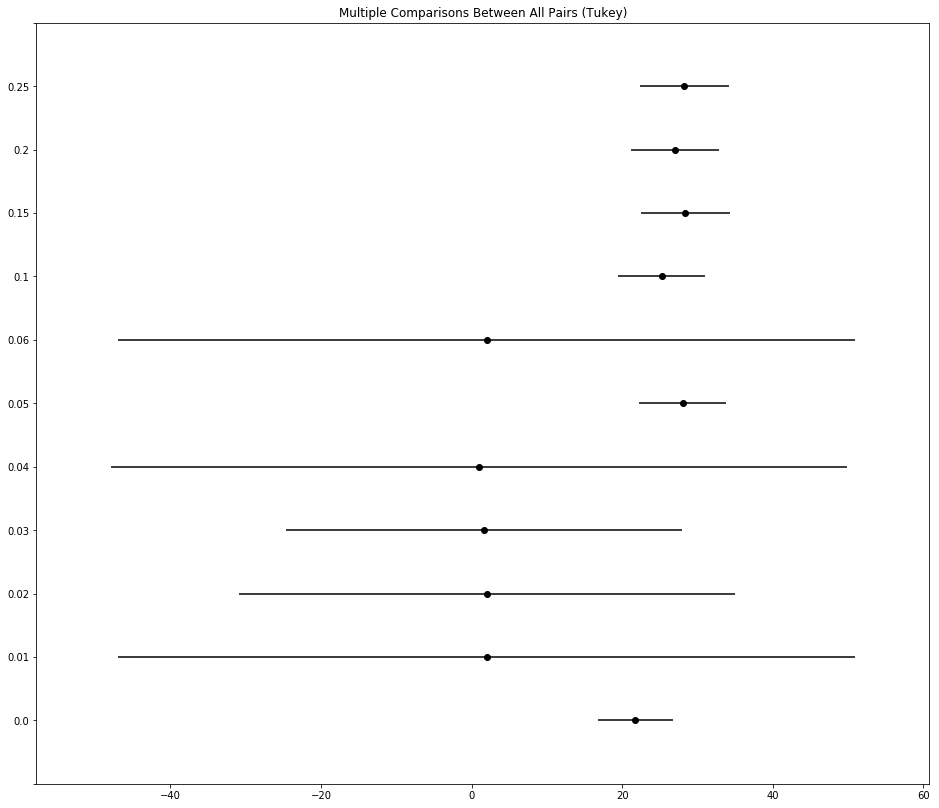

In [48]:
mc = MultiComparison(df['Quantity'], df['Discount'])
mc_results = mc.tukeyhsd()
print(mc_results)

mc_results = mc_results.plot_simultaneous(figsize=(16,14))
plt.show()

In [49]:
#5%, 10$, 15%, 20%, 25% all increase effect size of discount. 15% and 25% are the best discount rates.

In [ ]:
#https://medium.com/@trvlingteacher/hypothesis-testing-9d1fdf28e232